In [1]:
import scipy.spatial as spt
import numpy.linalg as la

def compute_squared_EDM_method5(X):
    V = spt.distance.pdist(X, 'sqeuclidean')
    return spt.distance.squareform(V)

def compute_squared_EDM_method5_modified(X):
    V = spt.distance.pdist(X, 'sqeuclidean')
    V = spt.distance.squareform(V)
    return spt.distance.squareform(V)

def compute_squared_EDM_method1(X):
    # determine dimensions of data matrix X
    m,n = X.shape
    # initialize squared EDM D
    D = np.zeros((n,n))
    # iterate over upper triangle of D
    for i in range(n):
        for j in range(i+1,n):
            D[i,j] = la.norm(X[:,i] - X[:,j])**2
            D[j,i] = D[i,j]
    return D

def compute_norm_2(rows):
    N = np.zeros((len(rows),len(rows)))
    for i in range(1,len(rows)):
        j = 0
        while j<i:
            norm = 0
            norm = rows[i] - rows[j]
            norm = np.sqrt(norm[0]**2+norm[1]**2)
            N[i,j] = norm
            j+=1
    return N

def k_search(pts, r):
    knn = np.zeros((len(pts),1), dtype=int)
    index = 0
    for rows in pts:
        knn[index] = np.count_nonzero(rows[np.where(rows<r)])
        index+=1
    return knn

## Importación de los datos de RA_DEC

In [2]:
import pickle
import numpy as np
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
flag = 0
for i in range(0,24):
    num = "0"+str(i) if i<10 else str(i)
    temp = pickle.load( open( "RA_DEC/"+num+".p", "rb" ) )
    if flag==0:
        t = temp
        flag=1
    else:
        t = vstack([t, temp])

### Se cambia las unidades de RA de [h] a [°]

In [3]:
t['RA'] = t['RA']*15

#### Grafica de los datos

<IPython.core.display.Javascript object>


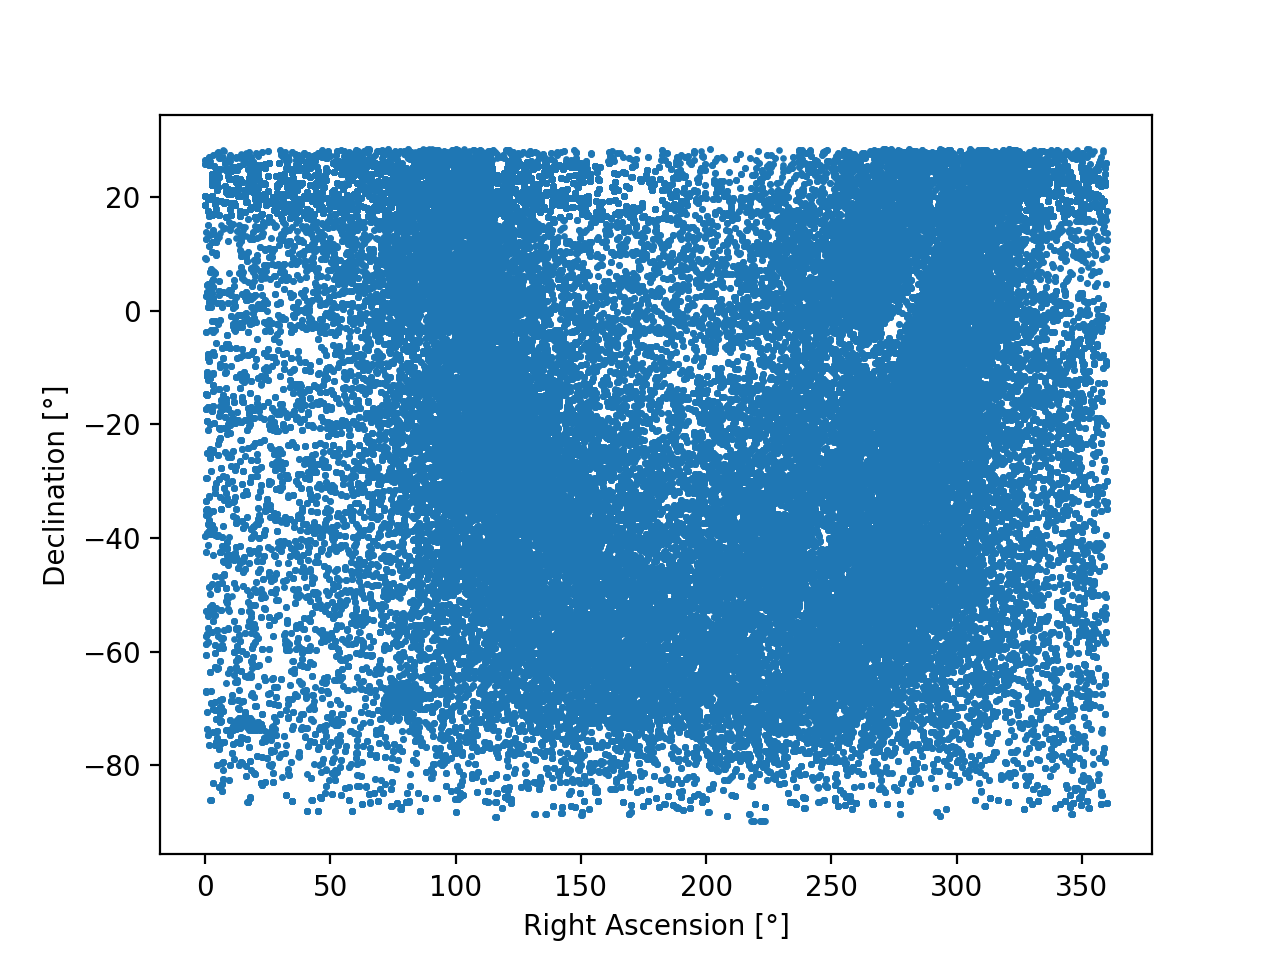

In [4]:
%matplotlib notebook
data = t
plt.scatter(data['RA'],data['DEC'],s=2)
plt.xlabel("Right Ascension [°]")
plt.ylabel("Declination [°]")
center = 0.2
l = 1
innerRadio = l
outerRadio = l*(2+np.sqrt(2))/2

## Función para cálculo de knn: método 1
Obtener las distancias de todos con todos

In [10]:
def testing_method1(t,lim,corte):
    try:
        data = t[0:lim]
        margin_x = 1
        margin_y = 1
        x_0 = min(data['RA'])
        x_n = max(data['RA'])
        y_0 = min(data['DEC'])
        y_n = max(data['DEC'])
        r = corte

        zona_operacion = [(x_0+margin_x, y_0+margin_y), (x_n-margin_x, y_n-margin_y)]
        puntos=[]
        for coordenada in data:
            puntos.append([coordenada[0],coordenada[1]])
        puntos = np.array(puntos)
        distancias = compute_squared_EDM_method5(puntos)

        cond_x = (puntos[0:-1,0]>= zona_operacion[0][0])&(puntos[0:-1,0]<= zona_operacion[1][0])
        cond_y = (puntos[0:-1,1]>= zona_operacion[0][1])&(puntos[0:-1,0]<= zona_operacion[1][1])
        mask = np.where(cond_x&cond_y)
        puntos_interes = puntos[mask]
        distancias_interes = distancias[mask]

        knn_1 = k_search(distancias_interes,r)
        
        return np.append(puntos_interes, knn_1, axis=1)
    #mask_2 = np.where(knn_1>5)
    except:
        return np.zeros((1,1),dtype=int)
        


# Obtención de KNN
## 1er approach: Distancia de todos con todos, qué tan costoso puede ser?
### Cálculo de la matríz distancia
Utilizando un arreglo (`rows`) de 3447 puntos bidimensionales se procede.
#### Usando compute_norm_2
Se usa el cálculo normal mediante for dentro de for, haciendo solo cálculos para la matríz diagonal superior.

    def compute_norm_2(rows):
        N = np.zeros((len(rows),len(rows)))
        for i in range(1,len(rows)):
            j = 0
            while j<i:
                norm = 0
                norm = rows[i] - rows[j]
                norm = np.sqrt(norm[0]**2+norm[1]**2)
                N[i,j] = norm
                j+=1
        return N

resultado con timeit:

    13.3 s ± 239 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    
#### Usando spt distance_matrix
    from scipy.spatial import distance_matrix
    distance_matrix(rows, rows)
resultado con timeit:

    488 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

#### Usando método 5, norma al cuadrado
    import scipy.spatial as spt
    def compute_squared_EDM_method5(X):
        V = spt.distance.pdist(X, 'sqeuclidean')
        return spt.distance.squareform(V)
resultado con timeit:

    85.7 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

#### Usando método 5, extrayendo raíz cuadrada
    np.sqrt(compute_squared_EDM_method5(rows))
resultado con timeit:
    
    115 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)





## 2do approach: Implementación de estrategia de ataque

### Estrategia 1

Obtener las distancia de todos con todos, luego discriminar por distancias para obtener el knn
#### Pasos:
* Definir parámetros

In [ ]:
# parametros a definir
margin_x = 1
margin_y = 1
r = 1
data = t[0:24000]
x_0 = min(data['RA'])
x_n = max(data['RA'])
y_0 = min(data['DEC'])
y_n = max(data['DEC'])

* Obtener matríz de diferencias

In [ ]:
zona_operacion = [(x_0+margin_x, y_0+margin_y), (x_n-margin_x, y_n-margin_y)]
puntos=[]
for coordenada in data:
    puntos.append([coordenada[0],coordenada[1]])
puntos = np.array(puntos)
distancias = compute_squared_EDM_method5(puntos)

* Filtrar con los márgenes

In [ ]:
cond_x = (puntos[0:-1,0]>= zona_operacion[0][0])&(puntos[0:-1,0]<= zona_operacion[1][0])
cond_y = (puntos[0:-1,1]>= zona_operacion[0][1])&(puntos[0:-1,0]<= zona_operacion[1][1])
mask = np.where(cond_x&cond_y)
puntos_interes = puntos[mask]
distancias_interes = distancias[mask]

* Buscar los k-vecinos mas cercanos para una distancia r utilizando
```
def k_search(pts, r):
    knn = np.zeros((len(pts),1), dtype=int)
    index = 0
    for rows in pts:
        knn[index] = np.count_nonzero(rows[np.where(rows<r)])
        index+=1
    return knn ```

In [5]:
def k_search(pts, r):
    knn = np.zeros((len(pts),1), dtype=int)
    index = 0
    for rows in pts:
        knn[index] = np.count_nonzero(rows[np.where(rows<r)])
        index+=1
    return knn

* Finalmente juntar esta información con los puntos correspondientes

In [ ]:
resultado = np.append(puntos_interes, knn_1, axis=1)

    array([[ 1.02744 , -8.311936, 19.      ],
           [ 1.028205, -8.312104, 19.      ],
           [ 1.028415, -8.31335 , 19.      ],
           ...,
           [27.48597 , -8.194771, 11.      ],
           [27.485985, -8.195136, 11.      ],
           [27.489495, -8.200164, 11.      ]])

Esta estrategia no es viable, dado que al haber muchos puntos, que será el caso, comienza a fallar por falta de memoria.

### Estrategia 1+2
* Definir parámetros

In [ ]:
# parametros a definir
r = 5
data = t

* Se tendrán la siguiente función de utilidad

##### Matriz de sectores
Se calculan las longitudes de la zona de operación, luego se crean los sectores y se rellena con 1 los límites, donde que tenga valor 1 evitará que se inspeccione ese sector.

    def m_sectores(data, r, flagx=1):
        x_0 = min(data['RA'])
        x_n = max(data['RA'])
        y_0 = min(data['DEC'])
        y_n = max(data['DEC'])
        l_x = (x_n-x_0)
        l_y = (y_n-y_0)
        subregions_x = int(l_x/r) if l_x%r == 0 else int(l_x/r+1)
        subregions_y = int(l_y/r) if l_y%r == 0 else int(l_y/r+1)
        s = (subregions_y,subregions_x+2)
        sectores = np.zeros(s,dtype=int)
        sectores[0,:] = 1
        sectores[-1,:] = 1
        if flagx==1:
            sectores[:,0] = 1
            sectores[:,-1] = 1
        return sectores
    
##### Cálculo del knn para un radio r dado:
    def k_search(pts, r):
        knn = np.zeros((len(pts),1), dtype=int)
        index = 0
        for rows in pts:
            knn[index] = np.count_nonzero(rows[np.where(rows<r)])
            index+=1
        return knn
        
##### Función que calcula el knn (método 1+2)
Para datos de 0° a 360°, dado un radio r y una matríz de sectores, que tiene la opción del flag para marcar o no en la matríz de sectores por donde ya ha pasado (flag_m=1 por omisión, es decir, marca por donde pasa).

    def knn_method2(data, r, sectores, flag_m=1):
        data = fix_xlimits(data)
        flag = 0
        y_0 = min(data['DEC'])
        y_0inf = int(y_0) if y_0%1 == 0 else int(y_0-1)
        for col in range(np.shape(sectores)[1]):
            xcenter = col*r+0.5*r
            xlim_izq = xcenter-1.5*r
            xlim_der = xcenter+1.5*r
            res_rows = []
            for row in range(np.shape(sectores)[0]):
                ycenter = row*r+0.5*r+y_0inf
                ylim_inf = ycenter-1.5*r
                ylim_sup = ycenter+1.5*r

                if sectores[row][col] == 1:
                    res_rows.append([-1])
                else:
                    if flag_m == 1:
                        sectores[row][col] = 1
                    cond_x = (data['RA']>= xlim_izq)&(data['RA']<xlim_der)
                    cond_y = (data['DEC']>= ylim_inf)&(data['DEC']< ylim_sup)
                    mask_op_sect = np.where(cond_x&cond_y)
                    data_aux = data[mask_op_sect]
                    cond_x = (data_aux['RA']>= xcenter-0.5*r)&(data_aux['RA']<xcenter+0.5*r)
                    cond_y = (data_aux['DEC']>= ycenter-0.5*r)&(data_aux['DEC']< ycenter+0.5*r)
                    mask_int_sect = np.where(cond_x&cond_y)
                    coordx = np.expand_dims(np.array(data_aux['RA']),axis=1)
                    coordy = np.expand_dims(np.array(data_aux['DEC']),axis=1)
                    data_aux = np.append(coordx,coordy,axis=1)
                    distances = compute_squared_EDM_method5(data_aux)
                    distances = distances[mask_int_sect]
                    knn = k_search(distances,r)
                    resultado = np.append(data_aux[mask_int_sect], knn, axis=1)
                    res_rows.append(resultado)
            if flag==0:
                res = res_rows
                flag=1
            else:
                if (np.ndim(res_rows) == 1):
                    res_rows = np.expand_dims(res_rows,axis=1)
                res = np.append(res,res_rows,axis=1)
        return res


In [4]:
import time
import pandas as pd
import pickle
from threading import Thread

def k_search(pts, r):
    knn = np.zeros((len(pts),1), dtype=int)
    index = 0
    for rows in pts:
        knn[index] = np.count_nonzero(rows[np.where(rows<r)])
        index+=1
    return knn

def m_sectores(data, r, flagx=1):
    x_0 = min(data['RA'])
    x_n = max(data['RA'])
    y_0 = min(data['DEC'])
    y_n = max(data['DEC'])
    l_x = (x_n-x_0)
    l_y = (y_n-y_0)
    subregions_x = int(l_x/r) if l_x%r == 0 else int(l_x/r+1)
    subregions_y = int(l_y/r) if l_y%r == 0 else int(l_y/r+1)
    s = (subregions_y,subregions_x+2)
    sectores = np.zeros(s,dtype=int)
    sectores[0,:] = 1
    sectores[-1,:] = 1
    if flagx==1:
        sectores[:,0] = 1
        sectores[:,-1] = 1
    return sectores

def fix_xlimits(data, r):
    x_0inf = int(min(data['RA']))
    x_n = max(data['RA'])
    x_nsup = int(x_n) if x_n%1 == 0 else int(x_n+1)
    cond_a = (data['RA']>= x_0inf)&(data['RA']<x_0inf+r)
    cond_b = (data['RA']>= x_nsup-r)&(data['RA']<x_nsup)
    mask = np.where(cond_a)
    temp = data[mask]
    temp['RA'] = temp['RA']+360
    data = vstack([data, temp])
    mask = np.where(cond_b)
    temp = data[mask]
    temp['RA'] = temp['RA']-360
    data = vstack([data, temp])
    return data

def knn_method2(data, r, flagx=1, flag_m=1):
    data = fix_xlimits(data, r)
    sectores = m_sectores(data, r, flagx)
    flag = 0
    y_0 = min(data['DEC'])
    y_0inf = int(y_0) if y_0%1 == 0 else int(y_0-1)
    x_0 = min(data['RA'])
    if x_0>0:
        x_0inf = int(x_0)
    else:
        x_0inf = int(x_0) if x_0%1 == 0 else int(x_0-1)
    d = r**r
    
    try:
        for col in range(np.shape(sectores)[1]):
            xcenter = col*r+0.5*r+x_0inf
            xlim_izq = xcenter-1.5*r
            xlim_der = xcenter+1.5*r
            res_rows = []
            for row in range(np.shape(sectores)[0]):
                ycenter = row*r+0.5*r+y_0inf
                ylim_inf = ycenter-1.5*r
                ylim_sup = ycenter+1.5*r

                if sectores[row][col] == 1:
                    res_rows.append(np.array([-1]))
                else:
                    if flag_m == 1:
                        sectores[row][col] = 1
                    cond_x = (data['RA']>= xlim_izq)&(data['RA']<xlim_der)
                    cond_y = (data['DEC']>= ylim_inf)&(data['DEC']< ylim_sup)
                    mask_op_sect = np.where(cond_x&cond_y)
                    data_aux = data[mask_op_sect]
                    cond_x = (data_aux['RA']>= xcenter-0.5*r)&(data_aux['RA']<xcenter+0.5*r)
                    cond_y = (data_aux['DEC']>= ycenter-0.5*r)&(data_aux['DEC']< ycenter+0.5*r)
                    mask_int_sect = np.where(cond_x&cond_y)
                    coordx = np.expand_dims(np.array(data_aux['RA']),axis=1)
                    coordy = np.expand_dims(np.array(data_aux['DEC']),axis=1)
                    data_aux = np.append(coordx,coordy,axis=1)
                    distances = compute_squared_EDM_method5(data_aux)
                    distances = distances[mask_int_sect]
                    data_aux = data_aux[mask_int_sect]
                    knn = k_search(distances,d)
                    mask = np.where(knn > 5)
                    data_aux = np.expand_dims(data_aux[mask],axis=1)
                    knn = np.expand_dims(knn[mask],axis=1)
                    resultado = np.append(data_aux, knn, axis=1)
                    res_rows.append(resultado)

            if (np.ndim(res_rows) == 1):
                res_rows = np.expand_dims(res_rows,axis=1)
            if flag==0:
                res = res_rows
                flag=1
            else:
                res = np.append(res,res_rows,axis=1)
    except:
        res = np.array([])
    return res

### Funciones automáticas para realizar calculos de tiempo
extract_time_RA_fix para dejar RA fijo y variar r.

extract_time_r_fix para dejar r fijo y variar RA.

In [5]:
def extract_time_RA_fix(RA_start, RA_stop, r_start, r_stop, data):  
    rows = []
    file = open("knn_data/log.txt","a+")
    for RA in range(RA_start, RA_stop+1):
        for r in range(r_start, r_stop+1):
            if (r<=RA):
                cond_x = (data['RA']>= 0)&(data['RA']<RA)
                mask = np.where(cond_x)
                data_aux = data[mask]
                n = len(data_aux)
                start = time.process_time()
                res = knn_method2(data_aux,r,0,1)
                end = time.process_time()
                wait = end - start
                if len(res)==0:
                    wait = -2
                    file.write(str(RA)+" "+str(n)+" "+str(r)+" "+str(wait)+"\n")
                print(RA, n, r, wait)
                rows.append([RA, n, r, wait])
        df = pd.DataFrame(rows,
                columns=['RA', 'n', 'r', 'time'])
        pickle.dump( df, open( "knn_data/0_to_"+str(RA)+".p", "wb" ) )
        print("saved to knn_data/0_to_"+str(RA)+".p")
        rows = []
    file.close()

def extract_time_r_fix(RA_start, RA_stop, r_start, r_stop, data):  
    rows = []
    file = open("knn_data/log.txt","a+")
    for r in range(r_start, r_stop+1):
        for RA in range(RA_start, RA_stop+1):
            if (r<=RA):
                cond_x = (data['RA']>= 0)&(data['RA']<RA)
                mask = np.where(cond_x)
                data_aux = data[mask]
                n = len(data_aux)
                start = time.process_time()
                res = knn_method2(data_aux,r,0,1)
                end = time.process_time()
                wait = end - start
                if len(res)==0:
                    wait = -2
                    file.write(str(RA)+" "+str(n)+" "+str(r)+" "+str(wait)+"\n")
                print(RA, n, r, wait)
                rows.append([RA, n, r, wait])
        df = pd.DataFrame(rows,
                columns=['RA', 'n', 'r', 'time'])
        pickle.dump( df, open( "knn_r_data/r_"+str(r)+".p", "wb" ) )
        print("saved to knn_r_data/r_"+str(r)+".p")
        rows = []
    file.close()

In [6]:
data = t
##subproceso1 = Thread(target=extract_time, args=(356, 360, 58, 100, data, ))
##subproceso1.start()
extract_time_r_fix(1,360,1,1,data)

1 207 1 17.28671028
2 437 1 17.885565995999997
3 717 1 19.789668823999996
4 980 1 19.802679350000005
5 1211 1 19.858338431999996
6 1423 1 20.007308146
7 1609 1 20.054633545
8 1772 1 19.946531254999996
9 1963 1 19.984081858999986
10 2183 1 20.017146723999986
11 2440 1 19.888603257
12 2710 1 19.996142360999983
13 2995 1 19.865048873999996
14 3215 1 19.97765053500001
15 3447 1 19.918106093999995
16 3677 1 19.87944497000001
17 3920 1 19.85668033799999
18 4183 1 19.916130162
19 4464 1 19.913339914999995
20 4740 1 19.965134331
21 5067 1 20.04513813699998
22 5319 1 19.815357499000015
23 5541 1 20.173203831000023
24 5770 1 19.94968998799999
25 5959 1 19.914568892000034
26 6162 1 19.93371080299994
27 6318 1 19.846441048999964
28 6502 1 19.34281136000004
29 6769 1 19.709834033999982
30 6995 1 19.804424053999924
31 7206 1 19.40051917699998
32 7414 1 19.611698923000063
33 7633 1 19.596099155000047
34 7884 1 19.268041061000076
35 8196 1 19.37047187899998
36 8478 1 19.424953410000057
37 8703 1 19.39

271 177531 1 26.981043156999476
272 179053 1 27.237259442999857
273 180507 1 26.543115780000335
274 182008 1 27.54968061999989
275 183793 1 27.669816065000305
276 185301 1 27.858269294999445
277 186904 1 28.226440988999457
278 188261 1 28.318214246000025
279 189639 1 28.874903662999714
280 191011 1 28.71974887899978
281 192383 1 29.0828423869998
282 193671 1 30.54496978899988
283 195074 1 29.112278184999923
284 196698 1 28.7614065989992
285 198276 1 28.670910403000562
286 199676 1 29.092181652999898
287 201057 1 29.17245684699992
288 202440 1 28.795066914000017
289 203734 1 29.451826712000184
290 204911 1 29.258960874999502
291 206154 1 29.10089693900045
292 207251 1 29.381505106000077
293 208468 1 30.093934194000212
294 209665 1 29.373186003000228
295 210952 1 30.13951219699993
296 211966 1 29.442773599999782
297 213027 1 29.857497392999903
298 214105 1 30.571757779999643
299 215105 1 30.838755716999913
300 216132 1 32.546318018999955
301 217103 1 30.86041668800044
302 217959 1 31.060

In [11]:
extract_time_r_fix(1,360,3,3,data)

3 717 3 2.154861921999327
4 980 3 2.300706755999272
5 1211 3 2.2002918889993452
6 1423 3 2.227974210998582
7 1609 3 2.3241167750002205
8 1772 3 2.59002640899962
9 1963 3 2.5880505990007805
10 2183 3 2.516103671001474
11 2440 3 2.4600805530008074
12 2710 3 2.2772423719998187
13 2995 3 2.205760441000166
14 3215 3 2.4339999510011694
15 3447 3 2.8191160230016976
16 3677 3 2.458510575999753
17 3920 3 2.3607818910004426
18 4183 3 2.463814562999687
19 4464 3 2.3621208320000733
20 4740 3 2.22497661899979
21 5067 3 2.2148864480004704
22 5319 3 2.2123605069991754
23 5541 3 2.4462382159999834
24 5770 3 2.4367989849997684
25 5959 3 2.417656530000386
26 6162 3 2.6473316690007778
27 6318 3 2.5222378710004705
28 6502 3 2.4515702680000686
29 6769 3 2.483204776999628
30 6995 3 2.4198545569997805
31 7206 3 2.232599124999979
32 7414 3 2.3730398129991954
33 7633 3 2.3476395640009287
34 7884 3 2.5335080299992114
35 8196 3 2.608608507000099
36 8478 3 2.450546359001237
37 8703 3 2.3401870140005485
38 8951 3 

276 185301 3 10.074147323999568
277 186904 3 10.195714331999625
278 188261 3 10.198285570000735
279 189639 3 10.352977899001417
280 191011 3 10.440438044000985
281 192383 3 10.546666831000039
282 193671 3 11.151274984998963
283 195074 3 10.89413306499955
284 196698 3 10.920917733999886
285 198276 3 11.178924961999655
286 199676 3 11.29722339699947
287 201057 3 11.232836589000726
288 202440 3 11.345464434998576
289 203734 3 11.497377129999222
290 204911 3 11.489997660999506
291 206154 3 11.591309292000005
292 207251 3 11.864202758000829
293 208468 3 11.72894111200003
294 209665 3 11.827433611999368
295 210952 3 11.978530562999367
296 211966 3 12.005644636999932
297 213027 3 12.042881658000624
298 214105 3 12.106827320998491
299 215105 3 12.105034763999356
300 216132 3 12.192346709000049
301 217103 3 12.208747476001008
302 217959 3 12.349479860000429
303 219010 3 12.28914823300147
304 219973 3 12.435083854999903
305 220903 3 12.797715421998873
306 221875 3 12.470448538999335
307 222738 3

In [6]:
import pickle
import numpy as np
import pandas as pd
flag = 0
for i in range(1,10,1):
    num = str(i)
    temp_df = pickle.load( open( "knn_r_data/r_"+num+".p", "rb" ) )
    #temp_df = pickle.load( open( "knn_data/0_to_"+num+".p", "rb" ) )
    if flag==0:
        df = temp_df
        flag=1
    else:
        df = df.append(temp_df)
arreglo = df.values

In [14]:
arreglo

array([[5.00000000e+00, 1.21100000e+03, 5.00000000e+00, 7.72120668e-01],
       [6.00000000e+00, 1.42300000e+03, 5.00000000e+00, 8.21857841e-01],
       [7.00000000e+00, 1.60900000e+03, 5.00000000e+00, 7.77533537e-01],
       ...,
       [3.58000000e+02, 2.47697000e+05, 9.00000000e+00, 1.22207335e+02],
       [3.59000000e+02, 2.47859000e+05, 9.00000000e+00, 1.22365096e+02],
       [3.60000000e+02, 2.48069000e+05, 9.00000000e+00, 1.22708302e+02]])

In [ ]:
import time
import pandas as pd
import pickle
from threading import Thread

rows = []
file = open("knn_data/log.txt","a+")
data = t
for RA in range(360,361):
    for r in range(1,101):
        if (r<=RA):
            cond_x = (data['RA']>= 0)&(data['RA']<RA)
            mask = np.where(cond_x)
            data_aux = data[mask]
            n = len(data_aux)
            start = time.process_time()
            res = knn_method2(data_aux,r,0,1)
            end = time.process_time()
            wait = end - start
            if len(res)==0:
                wait = -2
                file.write(str(RA)+" "+str(n)+" "+str(r)+" "+str(wait)+"\n")
            print(RA, n, r, wait)
            rows.append([RA, n, r, wait])
    if (RA%2== 0):
        df = pd.DataFrame(rows,
                columns=['RA', 'n', 'r', 'time'])
        pickle.dump( df, open( "knn_data/0_to_"+str(RA)+".p", "wb" ) )
        print("saved to knn_data/0_to_"+str(RA)+".p")
        rows = []
file.close()

360 248069 1 36.100528151999995
360 248069 2 12.629428284
360 248069 3 13.96797358900001
360 248069 4 21.733696347000006
360 248069 5 34.748350199000015
360 248069 6 51.65969623999999
360 248069 7 70.497747785
360 248069 8 93.48833544799999
360 248069 9 124.21218886499997
360 248069 10 142.00342176100003
360 248069 11 171.2719559850001
360 248069 12 200.403591313
360 248069 13 258.72606011200014
360 248069 14 -2
360 248069 15 -2
360 248069 16 -2
360 248069 17 -2
360 248069 18 -2
360 248069 19 -2
360 248069 20 -2
360 248069 21 -2
360 248069 22 -2
360 248069 23 -2
360 248069 24 -2
360 248069 25 -2
360 248069 26 -2
360 248069 27 -2
360 248069 28 -2


360 248069 1 32.888277156
360 248069 2 12.062724816
360 248069 3 13.186072795999998
360 248069 4 21.043711244
360 248069 5 33.53531587500001
360 248069 6 49.970483421
360 248069 7 68.92603013200002
360 248069 8 91.68760037399997
360 248069 9 120.15328979099996
360 248069 10 139.052238885
360 248069 11 167.714093251
360 248069 12 195.40970868600004
360 248069 13 245.40387419899992

#### Se guardan los datos asociados a los tiempos de ejecución y se cargan para prodecer con los gráficos de desempeño

In [61]:
arreglo = df.values
arreglo

array([[ 3.58000000e+02,  2.47697000e+05,  5.90000000e+01,
        -2.00000000e+00],
       [ 3.58000000e+02,  2.47697000e+05,  6.00000000e+01,
         1.12901785e+00],
       [ 3.58000000e+02,  2.47697000e+05,  6.10000000e+01,
         1.12928485e+00],
       [ 3.58000000e+02,  2.47697000e+05,  6.20000000e+01,
         1.15523175e+00],
       [ 3.58000000e+02,  2.47697000e+05,  6.30000000e+01,
         1.14585486e+00],
       [ 3.58000000e+02,  2.47697000e+05,  6.40000000e+01,
         1.15323177e+00],
       [ 3.58000000e+02,  2.47697000e+05,  6.50000000e+01,
         1.15328030e+00],
       [ 3.58000000e+02,  2.47697000e+05,  6.60000000e+01,
         1.13355192e+00],
       [ 3.58000000e+02,  2.47697000e+05,  6.70000000e+01,
         1.13338714e+00],
       [ 3.58000000e+02,  2.47697000e+05,  6.80000000e+01,
         1.14293928e+00],
       [ 3.58000000e+02,  2.47697000e+05,  6.90000000e+01,
         1.13713150e+00],
       [ 3.58000000e+02,  2.47697000e+05,  7.00000000e+01,
      

<IPython.core.display.Javascript object>


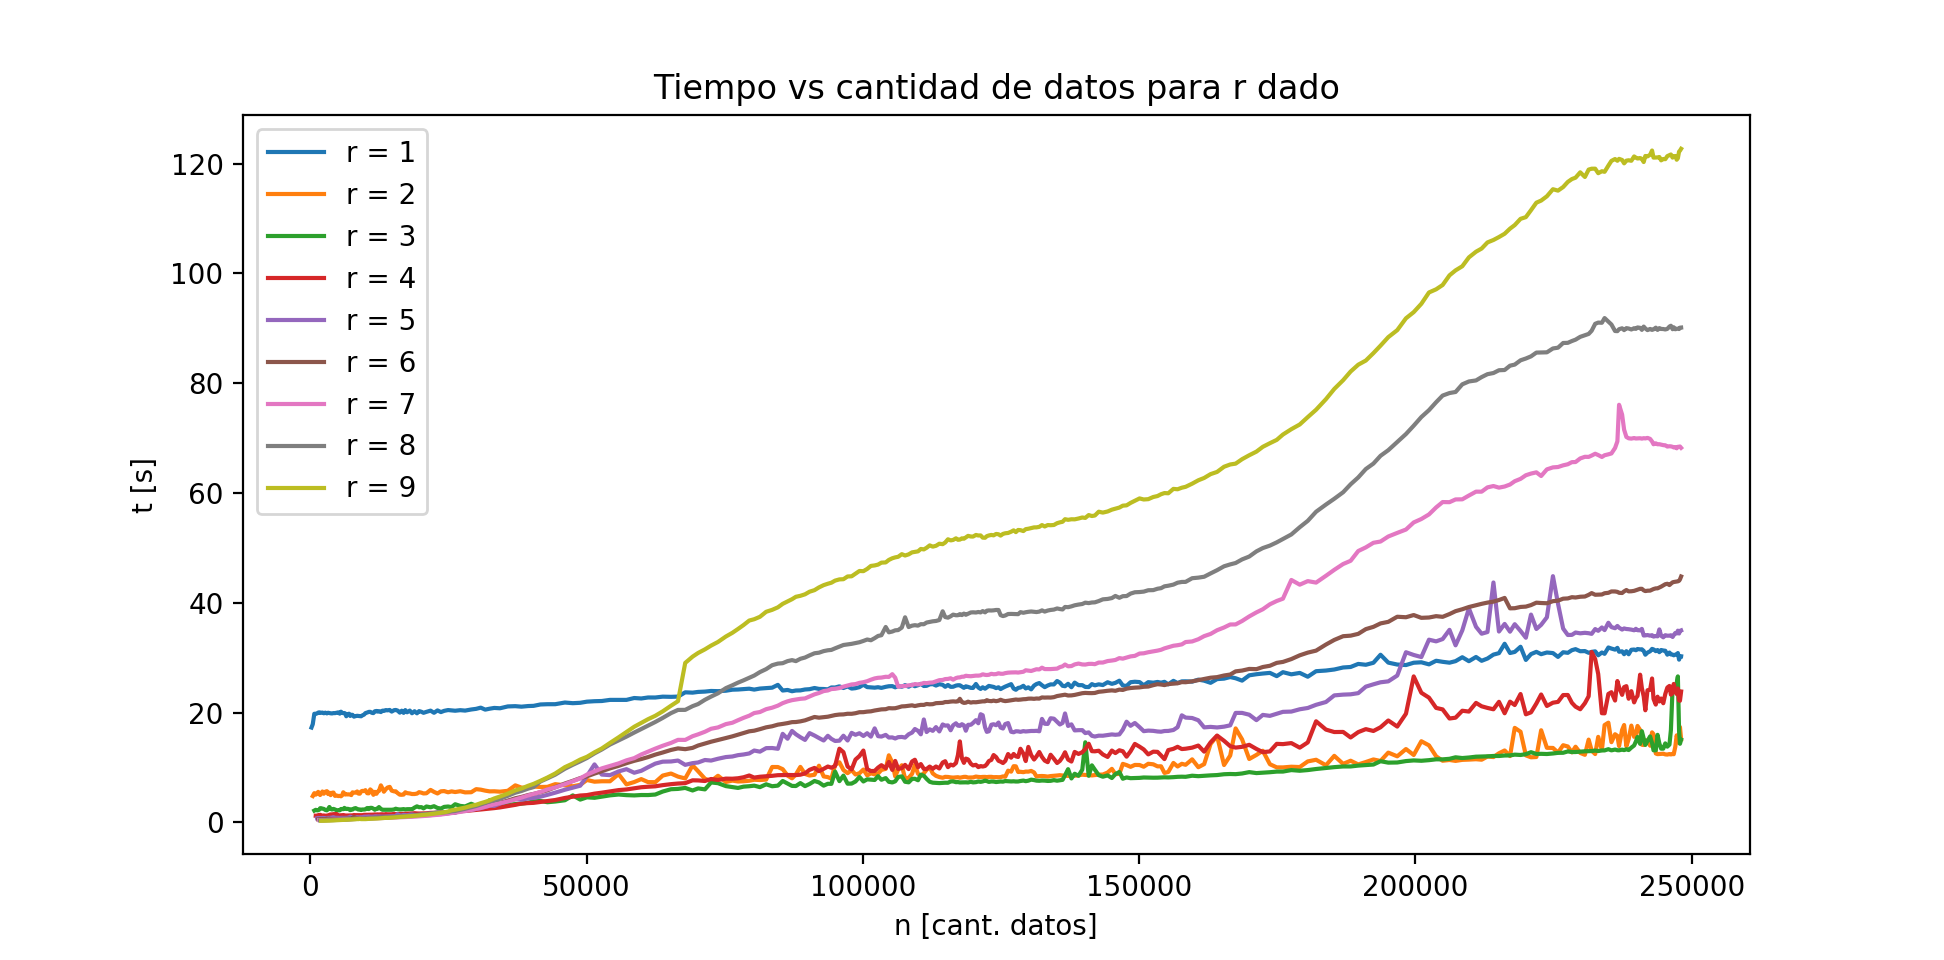

In [27]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
plt.hold
for i in range(1,10,1):
    mask = np.where((arreglo[:,2]==i)&(arreglo[:,-1]>0))
    arreglo_aux = arreglo[mask]
    plt.plot(arreglo_aux[:,-3],arreglo_aux[:,-1],label='r = '+str(i))
    
plt.legend()
plt.ylabel("t [s]")
plt.xlabel("n [cant. datos]")
plt.title("Tiempo vs cantidad de datos para r dado")
plt.savefig('t_vs_n.png')
plt.show()

In [32]:
int(max(arreglo[:,1])/5)

5822

<IPython.core.display.Javascript object>


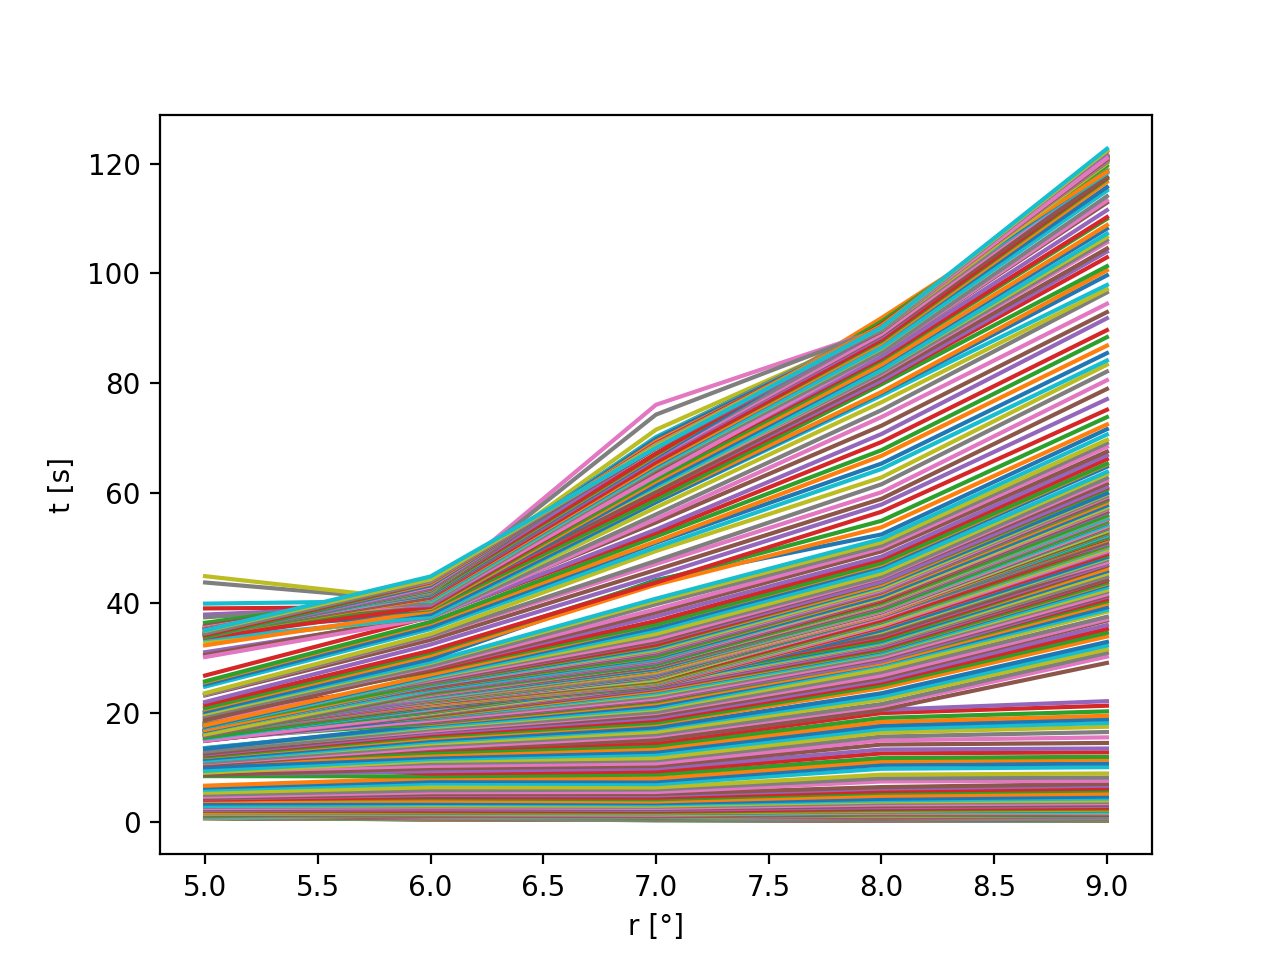

In [9]:
%matplotlib notebook
plt.figure()
plt.hold
for i in range(1, 361, 1):
    mask = np.where((arreglo[:,0]==i)&(arreglo[:,-1]>0))
    arreglo_aux = arreglo[mask]
    plt.plot(arreglo_aux[:,2],arreglo_aux[:,-1],label='RA = '+str(i))
    
#plt.legend()
plt.ylabel("t [s]")
plt.xlabel("r [°]")
plt.show()

In [ ]:
arreglo[:,0]

In [ ]:
%matplotlib notebook
plt.figure()
plt.scatter(arreglo[:,-3],arreglo[:,-1],s=2)
plt.ylabel("t [s]")
plt.xlabel("r [°]")
plt.show()

In [ ]:
y_0inf = int(y_0) if y_0%1 == 0 else int(y_0-1)
xcenter = 3*r+0.5*r
ycenter = 4*r+0.5*r+y_0inf
xlim_izq = xcenter-1.5*r
xlim_der = xcenter+1.5*r
ylim_inf = ycenter-1.5*r
ylim_sup = ycenter+1.5*r

cond_x = (data['RA']>= xlim_izq)&(data['RA']<xlim_der)
cond_y = (data['DEC']>= ylim_inf)&(data['DEC']< ylim_sup)
mask_op_sect = np.where(cond_x&cond_y)
data_aux = data[mask_op_sect]
cond_x = (data_aux['RA']>= xcenter-0.5*r)&(data_aux['RA']<xcenter+0.5*r)
cond_y = (data_aux['DEC']>= ycenter-0.5*r)&(data_aux['DEC']< ycenter+0.5*r)
mask_int_sect = np.where(cond_x&cond_y)
coordx = np.expand_dims(np.array(data_aux['RA']),axis=1)
coordy = np.expand_dims(np.array(data_aux['DEC']),axis=1)
data_aux = np.append(coordx,coordy,axis=1)
distances = compute_squared_EDM_method5(data_aux)
distances = distances[mask_int_sect]
knn_2 = k_search(distances,r)
resultado = np.append(data_aux[mask_int_sect], knn_2, axis=1)


In [ ]:
col1 = 3
row1 = 4
resultado2 = np.append(data_aux[mask_int_sect], knn_2, axis=1)

In [ ]:
row = []
row.append(np.array([1]))
row.append(np.array([2]))
row.append(np.array([3]))
row.append(resultado)

In [ ]:
row = np.expand_dims(row,axis=1)

In [ ]:
np.ndim(row)

In [ ]:
compute_squared_EDM_method5(np.array(data_aux))
array([[ 1.02744 , -8.311936, 19.      ],
       [ 1.028205, -8.312104, 19.      ],
       [ 1.028415, -8.31335 , 19.      ],
       ...,
       [27.48597 , -8.194771, 11.      ],
       [27.485985, -8.195136, 11.      ],
       [27.489495, -8.200164, 11.      ]])


### Estrategia 2
#### Pasos:
* Definir parámetros
* Obtener datos solo para la zona que se analizará
* Inicializar matríz de sectores
* Calcular matríz distancia por sectores de operación

In [ ]:
pool multiprocessing python